# Imports

In [2]:
# general
import torch
import numpy as np
from tqdm.notebook import tqdm
import random
import warnings

# data
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
from transformers import AutoModelForCausalLM, AutoTokenizer, default_data_collator
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import ExponentialLR

# custom
from utils import * # custom py file

/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/g.fidone/hlt/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
sns.set_theme(style="whitegrid", font='cmr10', font_scale=1.5)

# Reproducibility

In [4]:
SEED = 42
determinism = True
if determinism:
    set_deterministic_mode(SEED) # custom function (see utils.py)

# Data

In [5]:
train = load_dataset('json', data_files='subtaskB_train_sample.jsonl', split='train')
val = load_dataset('json', data_files='subtaskB_dev.jsonl', split='train')
test = load_dataset('json', data_files='subtaskB_test.jsonl', split='train')

In [6]:
print(train.shape, val.shape, test.shape)

(51139, 5) (3000, 5) (7103, 5)


In [7]:
model_tokenizer_path = 'mistralai/Mistral-7B-v0.1' 

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer_path) # initializing tokenizer
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [9]:
max_length = 110

In [10]:
train = train.map(
    lambda example: tokenize(example, tokenizer, max_length, labeled=True), # custom function (see utils.py)
    batched=True,
    desc="Running tokenizer on dataset",
)

In [11]:
val = val.map(
    lambda example: tokenize(example, tokenizer, max_length, labeled=True),
    batched=True,
    desc="Running tokenizer on dataset",
)

In [12]:
test = test.map( 
    lambda example: tokenize(example, tokenizer, max_length, labeled=False),
    batched=True,
    desc="Running tokenizer on dataset",
)

In [13]:
# input example (labeled)

tokenizer.decode(train[0]['input_ids'], skip_special_tokens=True)

'Text: "\n\n\nThese two skeins should be treated as if they were one, so make sure the two ends line up.\nBefore you start, make sure the yarn can unfurl from the skeins easily.;\n,\n\n\nThe yarn attached to the ball is the working yarn.\nMake sure the working yarn is to your left, and the tail is to your right.\n\n,,,,\n\n\nMake sure the loop is loose enough to move up " \nLabel: 0'

In [14]:
# input example (unlabeled)

tokenizer.decode(test[0]['input_ids'], skip_special_tokens=True)

'Text: "Athletics at the 2006 Commonwealth Games – Men\'s 200 metres Commonwealth Games was held in Delhi, India between 3 and 14 October 2006. The 200 metres event was held on the first day of the Games. Indian sprinter P.V. Sindhu won the most coveted gold medal of the Games. Two other Indian athletes, Sajjad Hiqal and Navendu Khat " \nLabel: '

In [15]:
train

Dataset({
    features: ['text', 'model', 'source', 'label', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 51139
})

In [16]:
val

Dataset({
    features: ['text', 'model', 'source', 'label', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3000
})

In [17]:
test

Dataset({
    features: ['text', 'model', 'source', 'label', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 7103
})

In [18]:
# saving y vectors – y_train is generated within the training loop, as train is shuffled over epochs

y_val = val['label']
y_test = test['label']

In [19]:
# removing unnecessary columns

train = train.remove_columns(['id', 'text', 'source', 'label', 'model'])
val = val.remove_columns(['id', 'text', 'source', 'label', 'model'])
test = test.remove_columns(['id', 'text', 'source', 'label', 'model'])

In [20]:
train

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 51139
})

In [21]:
val

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3000
})

In [22]:
test

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 7103
})

In [23]:
# converting to torch

train.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)
val.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)
test.set_format('pt', columns=['input_ids', 'attention_mask', 'labels'], output_all_columns=True)

In [24]:
batch_size = 8

In [25]:
def seed_worker(worker_id): # defining worker_init_fn for dataloader
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [26]:
train = DataLoader(
    train, 
    shuffle=True,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [27]:
val = DataLoader( 
    val, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

In [28]:
test = DataLoader(
    test, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

# Model

## Config

In [28]:
prompt_tuning_init_text = 'Decide if the text has been written by a human (0) or by a language model among: ChatGPT (1), Cohere(2), Davinci (3), Bloomz (4) or Dolly (5).'
print(len(tokenizer(prompt_tuning_init_text)['input_ids']))

51


In [29]:
# hyper-parameters

num_virtual_tokens = 51 # set as the length of prompt_tuning_init_text
lr = 1e-2
weight_decay = 2e-1 # default 1e-2
gamma = 0.95

In [30]:
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, 
    prompt_tuning_init=PromptTuningInit.TEXT, 
    num_virtual_tokens=num_virtual_tokens, 
    prompt_tuning_init_text=prompt_tuning_init_text,
    tokenizer_name_or_path=model_tokenizer_path,
)

In [31]:
model = AutoModelForCausalLM.from_pretrained(model_tokenizer_path, torch_dtype=torch.float16) # model loaded with half-precision
model = get_peft_model(model, peft_config)
print(model.print_trainable_parameters())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 208,896 || all params: 7,241,940,992 || trainable%: 0.002884530545481694
None


In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [33]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

In [34]:
check_cuda_memory() # custom function (see utils.py)

Current Tesla V100S-PCIE-32GB memory usage: 0.000/31.739 GiB


In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [36]:
check_cuda_memory()

Current Tesla V100S-PCIE-32GB memory usage: 13.990/31.739 GiB


## Training

In [37]:
num_epochs = 10
early_stopping = True

In [38]:
early_stopper = EarlyStopper(patience=2, delta=1e-2) # custom object (see utils.py)

train_losses = list()
val_losses = list()
train_pps = list()
val_pps = list()
train_accs = list()
val_accs = list()
train_f1s = list()
val_f1s = list()
    
# training loop

for epoch in range(num_epochs):
    model.train()
    train_loss = .0
    y_pred = list()
    y_train = list()
    for batch in tqdm(train, desc=f'Epoch {epoch}: training (TR)'):
        batch = {k: v.to(device) for k, v in batch.items()} # moving batches to gpu
        output = model(**batch) # teacher forcing
        loss = output.loss
        train_loss += loss.detach().float()
        predictions = torch.argmax(output.logits, -1).detach().cpu().numpy()
        y_pred.extend(predictions)
        y_train.extend(get_labels_from_dataloader(batch, tokenizer)) # custom function (see utils.py)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True reduces memory footprint
    lr_scheduler.step()

    y_pred = get_labels_from_predictions(y_pred, [0, 1, 2, 3, 4, 5], tokenizer) # custom function (see utils.py)
    train_epoch_loss = train_loss / len(train) # epoch loss as mean loss over iterations (batches)
    train_pp = torch.exp(train_epoch_loss) # pp as exponential of cross-entropy
    train_acc = round(accuracy_score(y_train, y_pred), 3)
    train_f1 = round(f1_score(y_train, y_pred, average='macro'), 3)

    model.eval()
    val_loss = .0
    y_pred = list()
    for batch in tqdm(val, desc=f'Epoch {epoch}: inference (VL)'):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output = model(**batch)
        loss = output.loss
        val_loss += loss.detach().float()
        predictions = torch.argmax(output.logits, -1).detach().cpu().numpy()
        y_pred.extend(predictions)

    y_pred = get_labels_from_predictions(y_pred, [0, 1, 2, 3, 4, 5], tokenizer) 
    val_epoch_loss = val_loss / len(val)
    val_pp = torch.exp(val_epoch_loss)
    val_acc = round(accuracy_score(y_val, y_pred), 3)
    val_f1 = round(f1_score(y_val, y_pred, average='macro'), 3)

    train_epoch_loss = train_epoch_loss.detach().cpu().item()
    val_epoch_loss = val_epoch_loss.detach().cpu().item()
    train_pp = train_pp.detach().cpu().item()
    val_pp = val_pp.detach().cpu().item()

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_pps.append(train_pp)
    val_pps.append(val_pp)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    print(f'Epoch {epoch}')
    print(f'TR Loss: {train_epoch_loss:12}\tVL Loss: {val_epoch_loss:12}')  # logging
    print(f'TR Accuracy: {train_acc:4}\t\tVL Accuracy: {val_acc:4}')
    print(f'TR F1: {train_f1:4}\t\t\tVL F1 (Macro): {val_f1:4}')
    
    if early_stopping:
        counter, stop = early_stopper(val_epoch_loss)
        if stop:
            print(f'Training early stopped at epoch {epoch}.')
            torch.save(model.state_dict(), f'mistral_B_epoch_{epoch}.pth')
            break
        if counter == 0:
            torch.save(model.state_dict(), f'mistral_B_epoch_{epoch}.pth') # saving model at optimal value of validation loss (before possible increase)

Epoch 0: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 325 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 0: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 0
TR Loss: 0.31230929493904114	VL Loss: 0.29245325922966003
TR Accuracy: 0.258		VL Accuracy: 0.16666666666666666
TR F1: 0.244			VL F1 (Macro): 0.04763265694960465


Epoch 1: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 102 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 1: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1
TR Loss: 0.24023793637752533	VL Loss: 0.19326151907444
TR Accuracy: 0.321		VL Accuracy: 0.4563333333333333
TR F1: 0.299			VL F1 (Macro): 0.3621972874173758


Epoch 2: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 62 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 2: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2
TR Loss: 0.17819735407829285	VL Loss: 0.18766653537750244
TR Accuracy: 0.516		VL Accuracy: 0.395
TR F1:  0.5			VL F1 (Macro): 0.3422372513946623


Epoch 3: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 14 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 3: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3
TR Loss: 0.14009416103363037	VL Loss: 0.1378944218158722
TR Accuracy: 0.613		VL Accuracy: 0.5706666666666667
TR F1: 0.605			VL F1 (Macro): 0.5077269304778885


Epoch 4: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 7 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 4: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4
TR Loss: 0.06651178002357483	VL Loss: 0.1326969861984253
TR Accuracy: 0.838		VL Accuracy: 0.7076666666666667
TR F1: 0.836			VL F1 (Macro): 0.6979136344435725


Epoch 5: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 23 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 5: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5
TR Loss: 0.0665026605129242	VL Loss: 0.13275191187858582
TR Accuracy: 0.844		VL Accuracy: 0.6683333333333333
TR F1: 0.842			VL F1 (Macro): 0.6623725053214414


Epoch 6: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 9 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 6: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6
TR Loss: 0.06652772426605225	VL Loss: 0.15252546966075897
TR Accuracy: 0.842		VL Accuracy: 0.6733333333333333
TR F1: 0.841			VL F1 (Macro): 0.655590852650021


Epoch 7: training (TR):   0%|          | 0/6393 [00:00<?, ?it/s]

/home/g.fidone/utils.py:113: UserWarning: A number of 237 labels have been randomly selected because generated labels did not match any expected label.
  warnings.warn(f'A number of {missed} labels have been randomly selected because generated labels did not match any expected label.', UserWarning)


Epoch 7: inference (VL):   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7
TR Loss: 0.23485304415225983	VL Loss: 0.2581677734851837
TR Accuracy: 0.425		VL Accuracy: 0.16666666666666666
TR F1: 0.426			VL F1 (Macro): 0.047755491881566386
Training early stopped at epoch 7.


/tmp/ipykernel_379971/494781718.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_losses, label='TR')


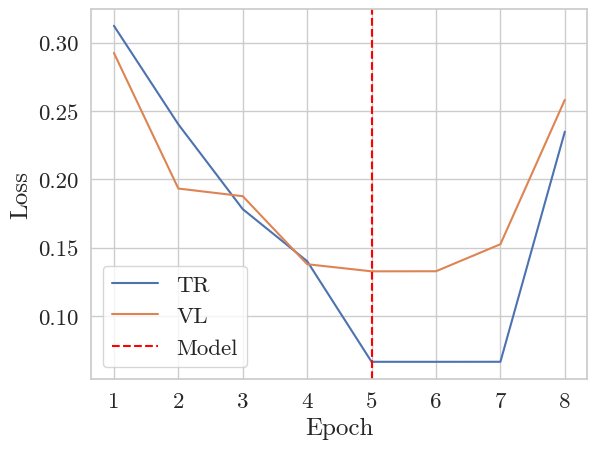

In [42]:
plt.plot(train_losses, label='TR')
plt.plot(val_losses, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8]) 
plt.legend()
plt.savefig('learning_curves_B.png',  bbox_inches="tight")
plt.show()

/tmp/ipykernel_378477/1901921175.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_accs, label='TR')


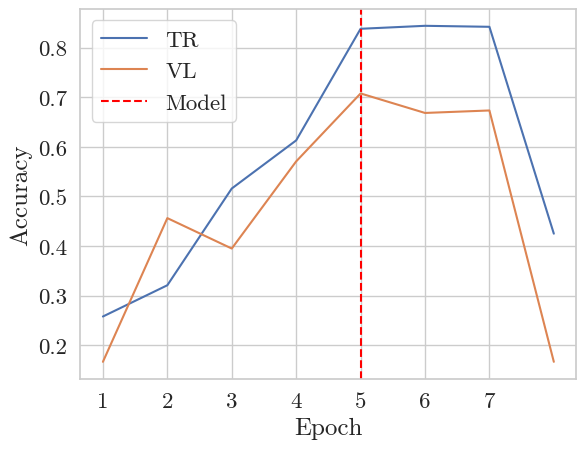

In [44]:
plt.plot(train_accs, label='TR')
plt.plot(val_accs, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]) 
plt.legend()
plt.savefig('accs_B.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_379971/3507218466.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_f1s, label='TR')


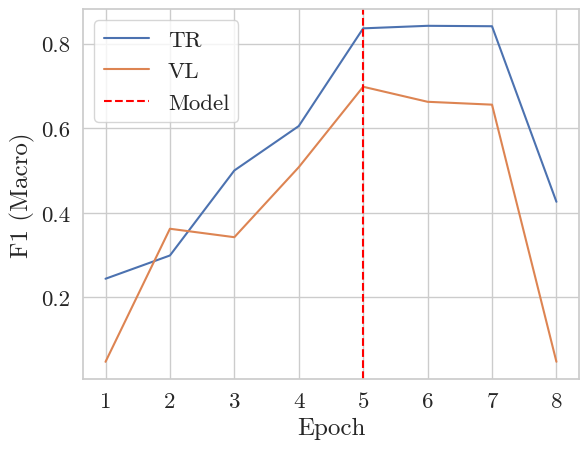

In [45]:
plt.plot(train_f1s, label='TR')
plt.plot(val_f1s, label='VL')
plt.xlabel('Epoch')
plt.ylabel('F1 (Macro)')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8]) 
plt.legend()
plt.savefig('f1s_B.png', bbox_inches="tight")
plt.show()

## Testing

In [29]:
prompt_tuning_init_text = 'Decide if the text has been written by a human (0) or by a language model among: ChatGPT (1), Cohere(2), Davinci (3), Bloomz (4) or Dolly (5).'
print(len(tokenizer(prompt_tuning_init_text)['input_ids']))

51


In [30]:
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, 
    prompt_tuning_init=PromptTuningInit.TEXT, 
    num_virtual_tokens=51, 
    prompt_tuning_init_text=prompt_tuning_init_text,
    tokenizer_name_or_path=model_tokenizer_path,
)

In [31]:
trained_parameters = 'mistral_B_epoch_4.pth' # file pth with model at epoch 4
model = AutoModelForCausalLM.from_pretrained(model_tokenizer_path, torch_dtype=torch.float16)
model = get_peft_model(model, peft_config)
model.load_state_dict(torch.load(trained_parameters)) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [33]:
outputs = list()
for step, batch in enumerate(tqdm(test)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # auto-regressive deterministic generation imposing max_new_tokens=1
            batch_out = model.generate(**batch, max_new_tokens=1, do_sample=False, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)
            decoded_batch_out = tokenizer.batch_decode(batch_out.detach().cpu().numpy(), skip_special_tokens=True)
            outputs.extend(decoded_batch_out)

  0%|          | 0/888 [00:00<?, ?it/s]

/home/g.fidone/hlt/lib/python3.10/site-packages/peft/peft_model.py:1166: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


In [34]:
y_pred = get_labels_from_texts(outputs, [0, 1, 2, 3, 4, 5]) # custom function (see utils.py)

In [35]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.844     0.941     0.890      1198
           1      0.885     0.860     0.872      1148
           2      0.854     0.925     0.888      1155
           3      0.928     0.608     0.735      1189
           4      0.833     0.998     0.908      1242
           5      0.856     0.829     0.842      1171

    accuracy                          0.861      7103
   macro avg      0.867     0.860     0.856      7103
weighted avg      0.866     0.861     0.856      7103



/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


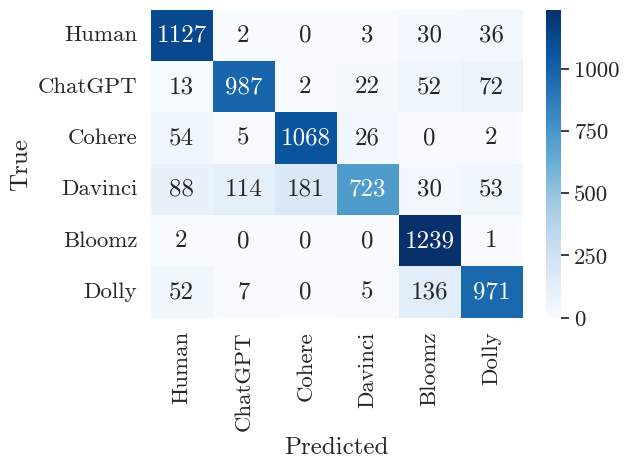

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'ChatGPT', 'Cohere', 'Davinci', 'Bloomz', 'Dolly'], yticklabels=['Human', 'ChatGPT', 'Cohere', 'Davinci', 'Bloomz', 'Dolly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('conf_B.png', bbox_inches="tight")
plt.show()